In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

In [ ]:
# Config

INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

# Training Params
BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 400
LEARNING_RATE = 1e-6
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_cnn_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
print("\nLoading all compressed features")

# Load the compressed .npz files
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33043, 150, 768)
y_train shape: (33043, 6)


In [7]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (28881, 150, 768)


In [8]:
print("\n Verifying final training set distribution after augmentation")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10203
WordRep         10040
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\n--- Building 1D CNN Model inside TPU Strategy Scope... ---")

    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

        x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)

        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


--- Building 1D CNN Model inside TPU Strategy Scope... ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 150, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,677 (1.64 MB)

 Trainable params: 427,909 (1.63 MB)

 Non-trainable params: 768 (3.00 KB)

LEARNING RATE: 1e-06
BATCH SIZE: 128


In [21]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753186948.534342      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5427053053835543430
I0000 00:00:1753186949.225021     804 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11513495230101163571), session_name()
I0000 00:00:1753186951.712890     804 tpu_compile_op_common.cc:245] Compilation of 11513495230101163571 with session name  took 2.478866499s and succeeded
I0000 00:00:1753186951.726866     804 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11513495230101163571), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5427053053835543430", property.function_library_fingerprint = 17147495452278311291, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1564 - auc: 0.4941 - loss: 0.7231 - precision: 0.3700 - recall: 0.5032

I0000 00:00:1753186959.346395     802 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9394136969546540592), session_name()
I0000 00:00:1753186962.068511     802 tpu_compile_op_common.cc:245] Compilation of 9394136969546540592 with session name  took 2.722074346s and succeeded
I0000 00:00:1753186962.079500     802 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9394136969546540592), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5427053053835543430", property.function_library_fingerprint = 17147495452278311291, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embedding_pa

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1564 - auc: 0.4941 - loss: 0.7231 - precision: 0.3700 - recall: 0.5031

I0000 00:00:1753186978.090522      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10218661188395744223
I0000 00:00:1753186978.478363     827 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16703626322472350041), session_name()
I0000 00:00:1753186979.285234     827 tpu_compile_op_common.cc:245] Compilation of 16703626322472350041 with session name  took 806.821163ms and succeeded
I0000 00:00:1753186979.288947     827 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16703626322472350041), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_10218661188395744223", property.function_library_fingerprint = 15262200072651736664, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap


Epoch 1: val_auc improved from -inf to 0.45593, saving model to best_cnn_model_tpu.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.1564 - auc: 0.4941 - loss: 0.7230 - precision: 0.3699 - recall: 0.5031 - val_accuracy: 0.1893 - val_auc: 0.4559 - val_loss: 0.6827 - val_precision: 0.4824 - val_recall: 0.4976
Epoch 2/400
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1568 - auc: 0.4998 - loss: 0.7181 - precision: 0.3597 - recall: 0.4827
Epoch 2: val_auc improved from 0.45593 to 0.48679, saving model to best_cnn_model_tpu.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.1568 - auc: 0.4999 - loss: 0.7180 - precision: 0.3598 - recall: 0.4828 - val_accuracy: 0.1625 - val_auc: 0.4868 - val_loss: 0.6832 - val_precision: 0.4508 - val_recall: 0.4614
Epoch 3/400
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1424 - auc: 0.5072 - loss: 0.7136 - precision: 0.3715 - recall: 0.4793
Epoch 3: val_auc improved from 0.48679 to 0.52057, saving model to best_


--- Evaluating Model on the Test Set ---
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.69      0.41      0.51      2613
       Block       0.63      0.32      0.42      3501
    SoundRep       0.61      0.42      0.50      1891
     WordRep       0.53      0.35      0.42      1742
Interjection       0.86      0.54      0.66      3344

   micro avg       0.69      0.41      0.51     13091
   macro avg       0.66      0.41      0.50     13091
weighted avg       0.68      0.41      0.51     13091
 samples avg       0.54      0.42      0.44     13091


--- Generating plots for model training history... ---


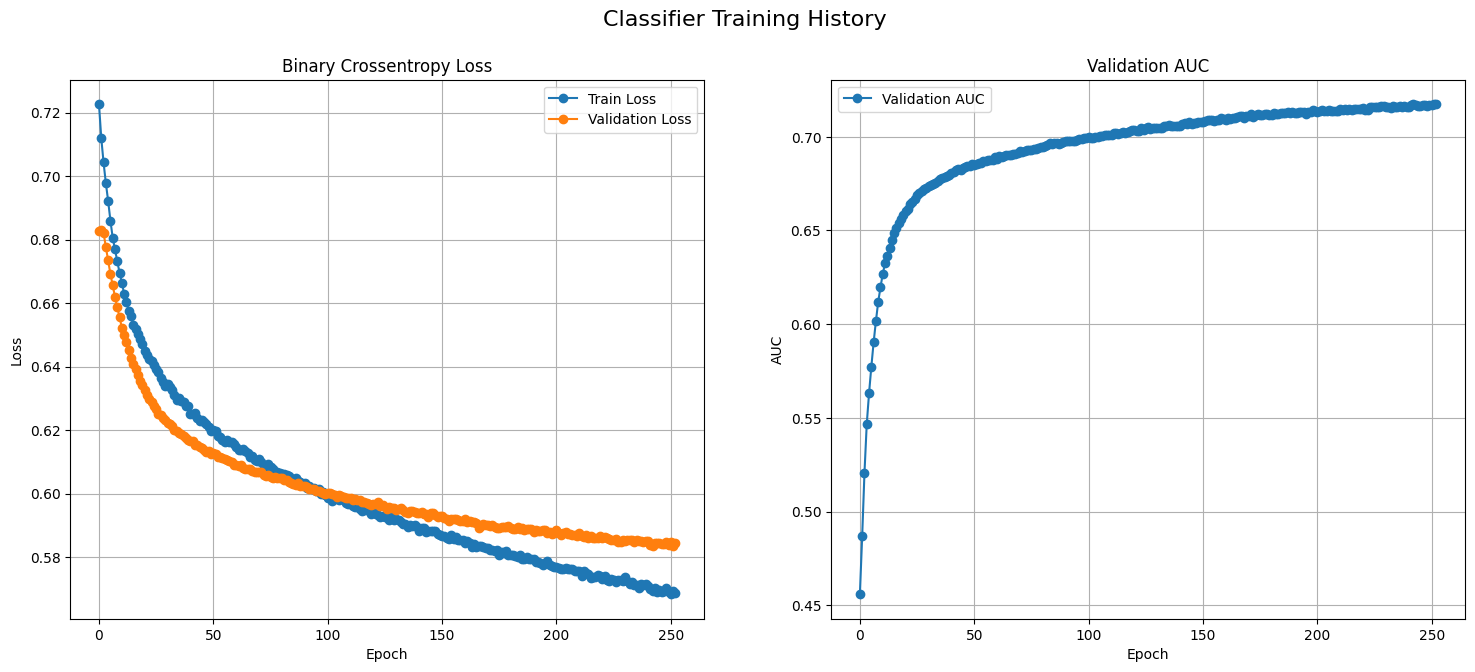


--- Generating Per-Class Confusion Matrices... ---


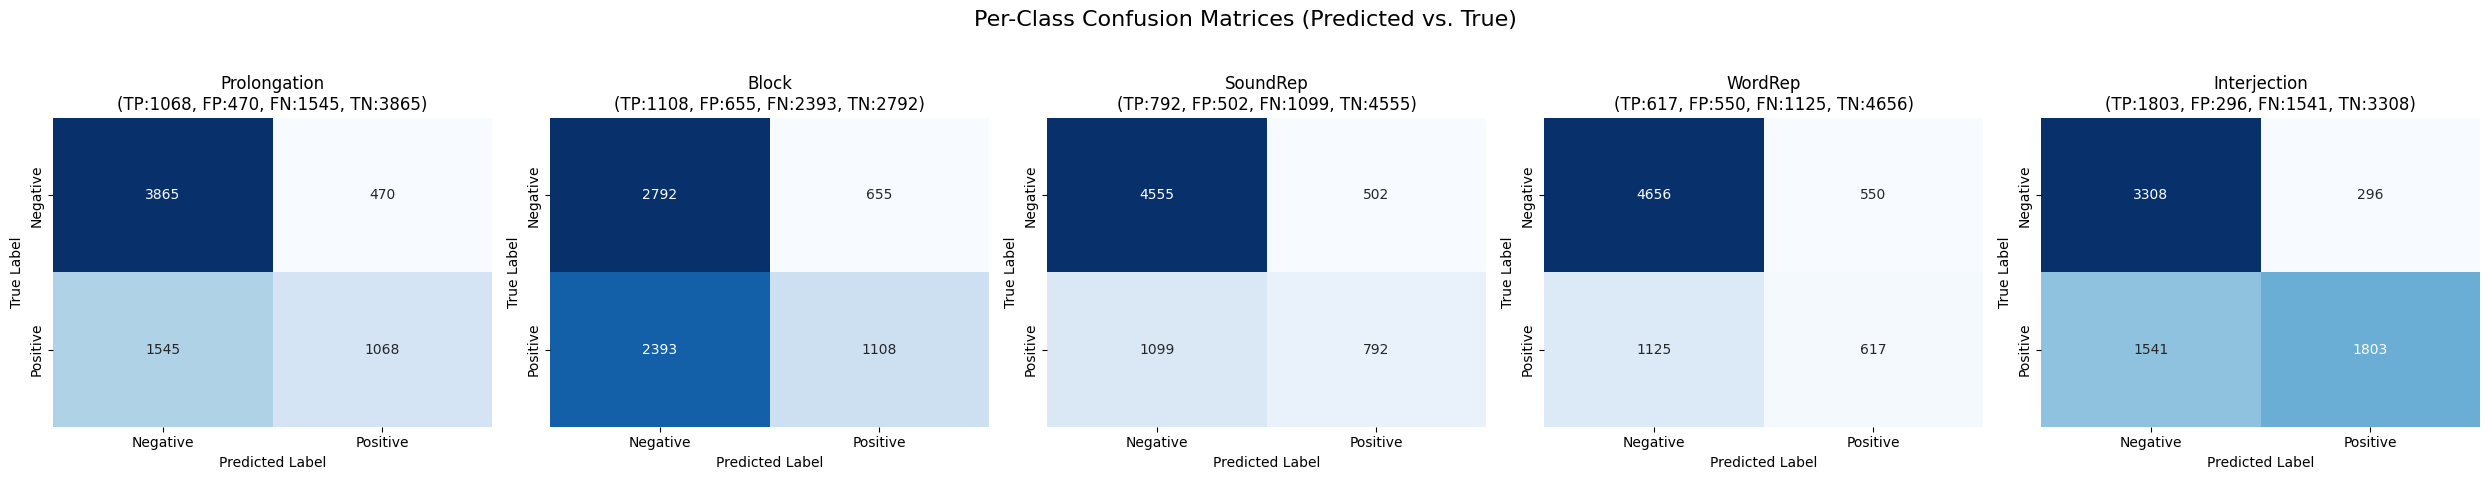


--- Generating Per-Class Precision-Recall Curves... ---


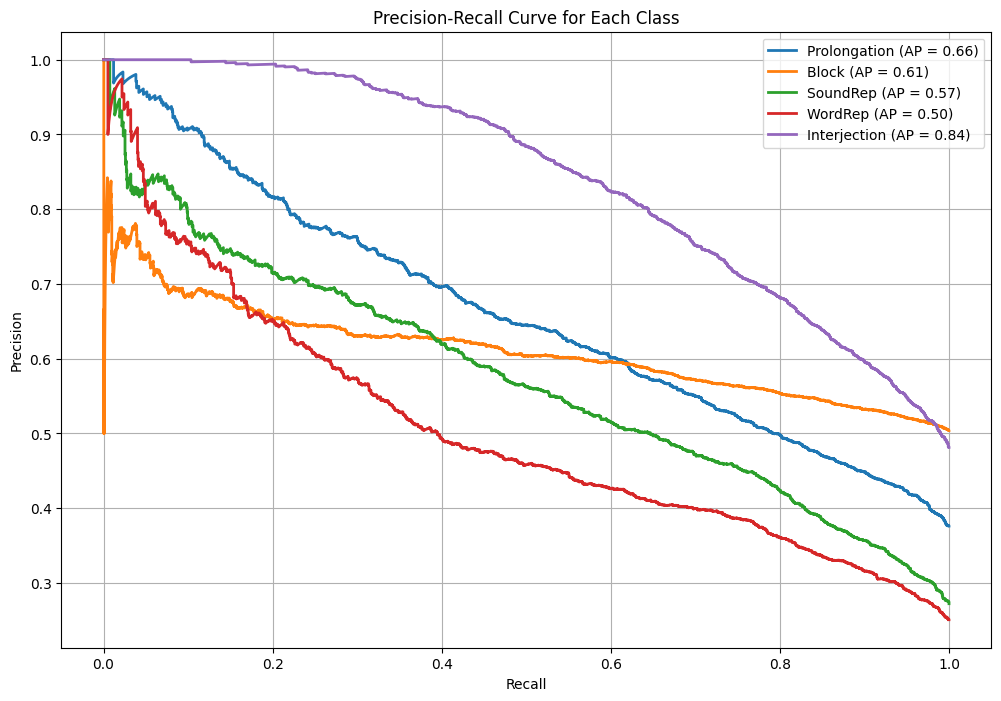

In [ ]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()

print("\n--- Generating Per-Class Confusion Matrices... ---")
mcm = multilabel_confusion_matrix(y_test_eval, y_pred_binary)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Per-Class Confusion Matrices (Predicted vs. True)', fontsize=16)

for i, (matrix, label) in enumerate(zip(mcm, LABEL_COLS)):
    tn, fp, fn, tp = matrix.ravel()
    ax = axes[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax.set_title(f'{label}\n(TP:{tp}, FP:{fp}, FN:{fn}, TN:{tn})')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(OUTPUT_DIR / "confusion_matrices.png")
plt.show()

print("\n--- Generating Per-Class Precision-Recall Curves... ---")
plt.figure(figsize=(12, 8))

for i in range(len(LABEL_COLS)):
    precision, recall, _ = precision_recall_curve(y_test_eval[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_test_eval[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{LABEL_COLS[i]} (AP = {ap:0.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve for Each Class")
plt.grid(True)
plt.savefig(OUTPUT_DIR / "precision_recall_curves.png")
plt.show()

